In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.cluster.hierarchy as hierarchy
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import knockadapt
import experiments


In [2]:
# Generate corr_matrix, Q
seed = 110
np.random.seed(seed)
sample_kwargs = {'coeff_size':10, 'method':'AR1', 'a':5, 'b':1}
S_kwargs = {
    'objective':'norm', 'norm_type':2, 'verbose':False, 'sdp_verbose':False
}

num_datasets = 5
n = 500
p = 100
q = 0.25

X0, y0, beta, Q, corr_matrix = knockadapt.graphs.sample_data(
    n = n, p = p, **sample_kwargs
)

In [3]:
from knockadapt.knockoff_stats import group_lasso_LCD, calc_nongroup_LSM, group_lasso_LSM


output = experiments.compare_methods(
    corr_matrix, 
    beta, 
    Q = Q, 
    n = n,
    q = q, 
    feature_fns = {'LSM':calc_nongroup_LSM, 'group_LCD':group_lasso_LCD},
                   #'group_LSM':group_lasso_LSM},
    S_kwargs = S_kwargs,
    num_data_samples = num_datasets,
)


Generating S matrices for complete now, time is 0.043692827224731445
Generating S matrices for single now, time is 149.53903365135193
Generating S matrices for average now, time is 311.12678813934326
Picking the best oracle!
At data sample 0 for oracle, time is 431.0861117839813
At data sample 1 for oracle, time is 463.74690556526184
At data sample 2 for oracle, time is 498.59294414520264
At data sample 3 for oracle, time is 530.755343914032
At data sample 4 for oracle, time is 564.3398566246033
Finished creating oracle: comparing methods now
At data sample 0 for methods, time is 597.7761921882629
At data sample 1 for methods, time is 672.3686919212341
At data sample 2 for methods, time is 743.1871325969696
At data sample 3 for methods, time is 812.6082737445831
At data sample 4 for methods, time is 882.4012453556061


In [4]:
from plotnine import *


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

In [5]:
melted_results, oracle_results, S_matrixes = output
id_vars = ['link_method', 'feature_fn', 'split_type', 'measurement']
method_means = melted_results.groupby(id_vars)['value'].mean().reset_index()
print(method_means)

   link_method feature_fn split_type               measurement     value
0      average        LSM     actual           empirical_power  0.112000
1      average        LSM     actual  expected_empirical_power  0.500267
2      average        LSM     actual                       fdr  0.188095
3      average        LSM     actual                     power  0.080000
4      average        LSM   nonsplit           empirical_power  0.378000
5      average        LSM   nonsplit                       fdr  0.100379
6      average        LSM   nonsplit                     power  0.328000
7      average        LSM     oracle           empirical_power  0.204000
8      average        LSM     oracle                       fdr  0.127778
9      average        LSM     oracle                     power  0.160000
10     average  group_LCD     actual           empirical_power  0.206000
11     average  group_LCD     actual  expected_empirical_power  0.232000
12     average  group_LCD     actual               

In [6]:
# Construct a (long) file name
fname = f'figures/initial/seed{seed}_n{n}_p{p}_N{num_datasets}'
sample_string = [
    ('').join([k.replace('_', ''), str(sample_kwargs[k])]) for k in sample_kwargs
]
sample_string = ('_').join(sample_string)
fname += '_'+sample_string

def plot_measurement_type(melted_results, 
                          method_means,
                          meas_type = 'power',
                          fname = None,
                          hline = None):

    results = melted_results.loc[melted_results['measurement'] == meas_type]
    results = results.rename(columns = {'value':meas_type})

    g1 = (
        ggplot(results, aes(
            x = 'feature_fn', y = meas_type, fill = 'split_type')
        )
        + geom_boxplot(position='dodge')
        + facet_grid('~link_method')
    )
    if hline is not None:
        g1 = g1 + hline
    
    if fname is not None:
        g1 = g1 + labs(title = fname)
        fname1 = fname + '_' + meas_type + '_v1.SVG'
        g1.save(fname1)
    print(g1)

    type_means = method_means.loc[method_means['measurement'] == meas_type]
    type_means = type_means.rename(columns = {'value':meas_type})

    g2 = (
        ggplot(type_means, aes(
            x = 'feature_fn', y = meas_type, fill = 'split_type')
        )
        + geom_col(position='dodge')
        + facet_grid('~link_method')
    )
    
    if hline is not None:
        g2 = g2 + hline
        
    if fname is not None:
        g2 = g2 + labs(title = fname)
        fname1 = fname + '_' + meas_type + '_v2.SVG'
        g2.save(fname2)        
    print(g2)

## Power Results

/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/initial/seed110_n500_p100_N5_coeffsize10_methodAR1_a5_b1_power_v1.SVG
  warn('Filename: {}'.format(filename), PlotnineWarning)


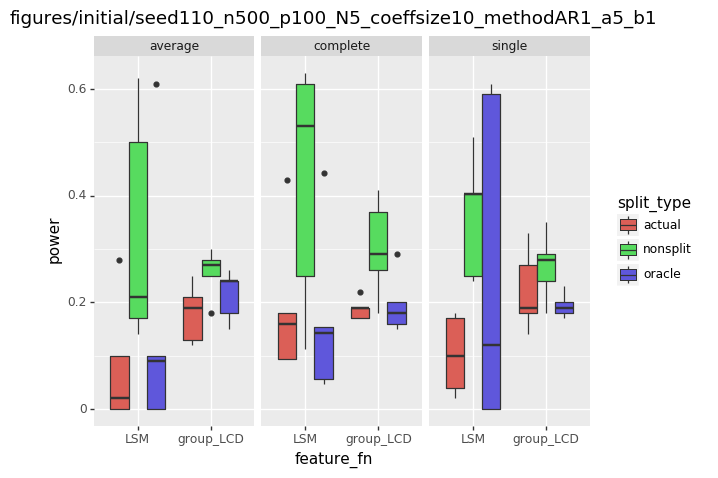

<ggplot: (8780964339106)>


/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/initial/seed110_n500_p100_N5_coeffsize10_methodAR1_a5_b1_power_v2.SVG
  warn('Filename: {}'.format(filename), PlotnineWarning)


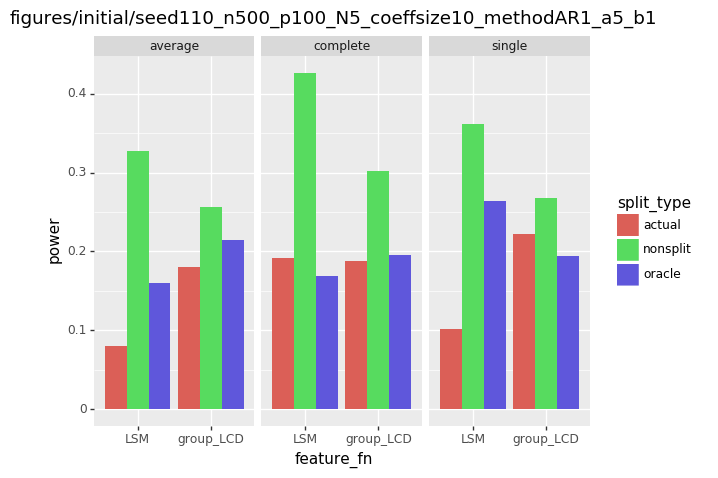

<ggplot: (-9223363255934795141)>


In [7]:
plot_measurement_type(melted_results, method_means, meas_type = 'power', fname = fname)

/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/initial/seed110_n500_p100_N5_coeffsize10_methodAR1_a5_b1_power_v1.SVG
  warn('Filename: {}'.format(filename), PlotnineWarning)


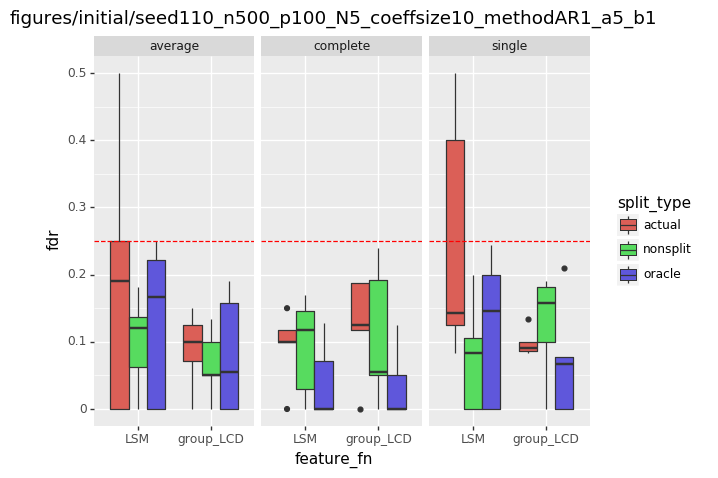

<ggplot: (-9223363255934972258)>


/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/initial/seed110_n500_p100_N5_coeffsize10_methodAR1_a5_b1_power_v2.SVG
  warn('Filename: {}'.format(filename), PlotnineWarning)


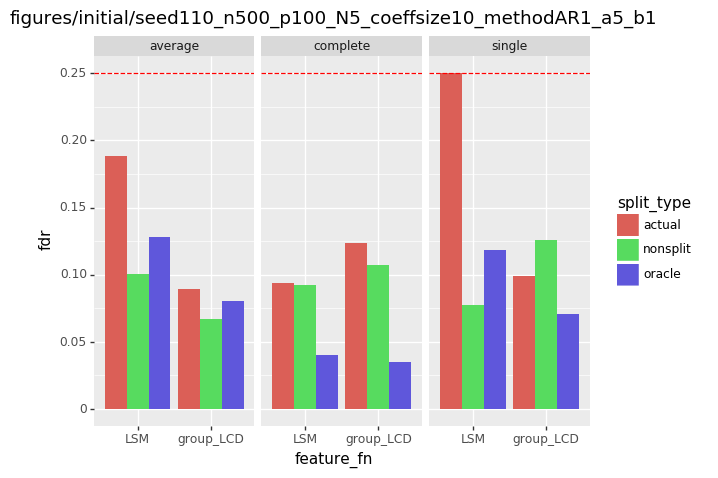

<ggplot: (8780919697486)>


In [8]:
hline = geom_hline(aes(yintercept = 0.25), linetype="dashed", color = "red")
plot_measurement_type(melted_results, method_means, meas_type = 'fdr', hline = hline,
                      fname = fname)